# Churn - Processing the Raw Data

### The origninal data files for churn example are:

### Files

1. **train.csv** size(44.5MB) about 1 million rows.

    the train set, containing the user ids and whether they have churned.

 + msno: user id
 + is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

2. **sample_submission_zero.csv** size(43.5MB) 970,960 rows

    the test set, containing the user ids, in the format that we expect you to submit

 + msno: user id
 + is_churn: This is what you will predict. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

3. **transactions.csv** size(1.6GB) 21,547,746 rows

    transactions of users up until 2/28/2017.

 + msno: user id
 + payment_method_id: payment method
 + payment_plan_days: length of membership plan in days
 + plan_list_price: in New Taiwan Dollar (NTD)
 + actual_amount_paid: in New Taiwan Dollar (NTD)
 + is_auto_renew
 + transaction_date: format %Y%m%d
 + membership_expire_date: format %Y%m%d
 + is_cancel: whether or not the user canceled the membership in this transaction.

4. **user_logs.csv** size(28.4GB) 392,106,544 rows

    daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.

 + msno: user id
 + date: format %Y%m%d
 + num_25: # of songs played less than 25% of the song length
 + num_50: # of songs played between 25% to 50% of the song length
 + num_75: # of songs played between 50% to 75% of of the song length
 + num_985: # of songs played between 75% to 98.5% of the song length
 + num_100: # of songs played over 98.5% of the song length
 + num_unq: # of unique songs played
 + total_secs: total seconds played

5. **members.csv** size(352MB) 5,116,194 rows

    user information. Note that not every user in the dataset is available.

 + msno
 + city
 + bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
 + gender
 + registered_via: registration method
 + registration_init_time: format %Y%m%d
 + expiration_date: format %Y%m%d
 + Data Extraction Details


### Note:
One important information in the data extraction process is the definition of membership expiration date. Suppose we have a sequence for a user with the tuple of (transaction date, membership expiration date, and is_cancel):

(2017-01-01, 2017-02-28, false)

(2017-02-25, 0217-03-15, false)

(2017-04-30, 3017-05-20, false)

(data used for demo only, not included in competition dataset)

This user is included in the dataset since the expiration date falls within our time period. Since the subscription transaction is 30 days away from 2017-03-15, the previous expiration date, we will count this user as a churned user.

Let's consider a more complex example derive the last one, suppose now a user has the following transaction sequence

(2017-01-01, 2017-02-28, false)

(2017-02-25, 2017-04-03, false)

(2017-03-15, 2017-03-16, true)

(2017-04-01, 3017-06-30, false)

The above entries is quite typical for a user who changes his subscription plan. Entry 3 indicates that the membership expiration date is moved from 2017-04-03 back to 2017-03-16 due to the user making an active cancellation on the 15th. On April 1st, the user made a long term (two month subscription), which is 15 days after the "current" expiration date. So this user is not a churn user.

Now let's consider the a sequence that indicate the user does not falls in our scope of prediction

(2017-01-01, 2017-02-28, false)

(2017-02-25, 2017-04-03, false)

(2017-03-15, 2017-03-16, true)

(2017-03-18, 2017-04-02, false)

Note that even the 3rd entry has member ship expiration date falls in 2017-03-16, but the fourth entry extends the membership expiration date to 2017-04-02, not between 2017-03-01 and 2017-03-31, so we will not make a prediction for the user.

## Limitation of Resources

When handling large files, sometimes you are limited by resources: memory, disk space, time, etc.

Therefore, from the begining of a project that may involve large files, one need to develop a plan to address this problem.

### Memory usage

To optimize the usage of memory, followings are some useful tips:
1. Choose the "right" data types
2. When read in large files, larger than your sys memory, try read in by chunks (e.g., for csv files, you can choose to read in how many row or columns). Process chunks while reading.
3. recycle the object names, in python, names are shared views, a reference to say, data, but use with care, for some types, it may lead to confusion. 
4. use garbage collection.


### CPU usage

1. Use multi-core processing wherever possible
2. Use GPU wherever possible

In [2]:
import sys
import gc; gc.enable()# python garbage collection module, gc.enable() enables automatic garbage collection
import pandas as pd
import numpy as np
import time 
import datetime

# Caution: some of the code in this notebook may run for a long time, make sure you have enough time when you want to try all of code out!

## Next step, feature extraction from user_log

**user_logs.csv** size(28.4GB) 392,106,544 rows

    daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.

 + msno: user id
 + date: format %Y%m%d
 + num_25: # of songs played less than 25% of the song length
 + num_50: # of songs played between 25% to 50% of the song length
 + num_75: # of songs played between 50% to 75% of of the song length
 + num_985: # of songs played between 75% to 98.5% of the song length
 + num_100: # of songs played over 98.5% of the song length
 + num_unq: # of unique songs played
 + total_secs: total seconds played

### 1. Read in only selected columns

use pd.read_csv(), `usecols=[  ]` argument will specify which column(s) to read in.

In [ ]:
s=time.time()
logs=pd.read_csv('../data/churn/user_logs.csv',usecols=['msno'])
print(time.time()-s)

In [ ]:
logs.memory_usage().sum()/1024**2

In [ ]:
logs.head(10)

In [ ]:
logs=pd.DataFrame(logs['msno'].value_counts().reset_index())#count how many log entries each 'msno' has

In [ ]:
logs.columns = ['msno','logs_count']#rename the columns names

In [ ]:
logs.shape

### 2. Read in by chunks

When read in large files, one can read in by chunks, in pandas read_csv(), you can specify the **chunsize**.

Or you can specify how many rows you want to read, with say, **`nrows = 10000`** to read in 10,000 rows.

Another trick is that you can create an **iterator** to read in file by chunks, so you don't need to remember where you stop and where you should continue to read. the 'iterator=True' indicates to use as an iterator.


In [15]:
df_iter = pd.read_csv('../data/churn/user_logs.csv', low_memory=False, iterator=True, chunksize=10*1024**2,
                        dtype={'num_25':'float16','num_50':'float16','num_75':'float16','num_985':'float16',
                               'num_100':'float16','num_unq':'float16','total_secs':'float32'},
                        parse_dates=['date'], infer_datetime_format =True)


### 2.1 Goal = Read in user logs by chunks and retain only last 10 daily logs for all 'msno'

#### Strategy:
1. Create an iterator to read in the csv by chunks.
2. Process the chunk in the following way:
  1. Sort by 'msno' and then by 'date'
  2. Use groupby (by 'msno') to keep only last 10 rows of each 'msno', if fewer than 10, keep all.
  3. Merge with training dataset, use inner join, keep those in both chunk and train, to reduce memory usage.
  4. Drop 'is_churn', because in the future we will still merge with new data, overlapping will use more memory.
  5. store the processed chunk in a list.
  5. Read in next chunk, concat with the previous processed chunk, and repeat A through E.
3. Create a function to do step 2A-2D

In [ ]:
train_id=pd.read_csv('../data/churn/train.csv',dtype={'is_churn':'bool'}) # read in train to get the 'msno' ids.

In [16]:
logs_part=[] #to store the processed chunk for concat later.
def df_log(df):
    df.sort_values(['msno','date'],inplace=True)
    df=df.groupby('msno').nth(list(range(-10,0))).reset_index() #keep the last 10 daily logs.
    df=pd.merge(df,train_id,how='inner',on='msno') # keep only those 'msno's that are in both this chunk and train dataset
    df.drop('is_churn',axis=1,inplace=True) 
    return df                

In [18]:
s=time.time()
chunk_time=[] # to store the processing time for each chunk
i=0
for df in df_iter:
    df=df_log(df)
    logs_part.append(df)
    df=[] #try to realse the used memory
    
    if i!=0: # to concat from the second chunk
        logs_part=pd.concat(logs_part, axis=0, ignore_index=True).reset_index(drop=True) # concat this chunk with previous chunks
        logs_part=df_log(logs_part) #process the combined chunk
        logs_part=[logs_part] #make it into a list for next concat
    
    i+=1
    print('Processed {}th chunk'.format(i))
    print('Used {:.of} seconds\n'.format(time.time()-s))
    print('The shape of processed df is {}.\n'.format(logs_part[0].shape))
    chunk_time.append(time.time()-s)
    s=time.time()

Processed 1th chunk
Used 39.5532500743866 seconds

The shape of processed df is (4950580, 9).

Processed 2th chunk
Used 51.12378406524658 seconds

The shape of processed df is (6394588, 9).

Processed 3th chunk
Used 53.012107849121094 seconds

The shape of processed df is (6960697, 9).

Processed 4th chunk
Used 59.79203963279724 seconds

The shape of processed df is (7276286, 9).

Processed 5th chunk
Used 56.787784576416016 seconds

The shape of processed df is (7440363, 9).

Processed 6th chunk
Used 56.97713232040405 seconds

The shape of processed df is (7592272, 9).

Processed 7th chunk
Used 55.69054341316223 seconds

The shape of processed df is (7730380, 9).

Processed 8th chunk
Used 55.175307750701904 seconds

The shape of processed df is (7810675, 9).

Processed 9th chunk
Used 58.137455701828 seconds

The shape of processed df is (7843311, 9).

Processed 10th chunk
Used 61.46826362609863 seconds

The shape of processed df is (7874893, 9).

Processed 11th chunk
Used 58.3967831134

In [22]:
print('Total time processing log file is {:.0f} seconds'.format(sum(chunk_time)))

Total time processing log file is 2160 seconds


In [23]:
logs_part[0].shape

(8408773, 9)

In [24]:
logs_part[0].memory_usage().sum()/1024**2

320.7692337036133

In [25]:
msno=logs_part[0].msno.unique()

In [26]:
len(msno)

869926

In [31]:
logs=logs_part[0]
logs_part=[]

In [39]:
logs.head(20)

,msno,date,num_100,num_25,num_50,num_75,num_985,num_unq,total_secs
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-19,17.0,3.0,0.0,1.0,0.0,20.0,4788.622070
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-20,21.0,5.0,4.0,5.0,6.0,35.0,7344.375000
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-21,5.0,4.0,2.0,4.0,3.0,18.0,2634.316895
3,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-22,28.0,4.0,3.0,4.0,8.0,41.0,9460.650391
4,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-23,19.0,3.0,1.0,2.0,10.0,31.0,7201.288086
5,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-24,3.0,1.0,2.0,0.0,2.0,7.0,1358.760010
6,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-25,17.0,6.0,2.0,1.0,2.0,25.0,5207.749023
7,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-26,4.0,1.0,0.0,0.0,1.0,6.0,1369.876953
8,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-27,34.0,4.0,4.0,3.0,5.0,43.0,10490.561523
9,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-28,42.0,13.0,3.0,1.0,2.0,49.0,11129.182617


In [34]:
logs.to_csv('../data/churn/last_ten_logs.csv',index=False)

### 2.2 Log feature extraction

**2.2.1 Variables for each row in logs:**

+ Column that has max number of songs in ['num_25','num_50','num_75','num_985','num_100']
+ Column that has min number of songs in ['num_25','num_50','num_75','num_985','num_100']
+ Total songs listened = sum(['num_25','num_50','num_75','num_985','num_100'])
+ num_100 to total song ratio = num_100 / total song
+ Unique song ratio = ['num_unq'] / sum(['num_25','num_50','num_75','num_985','num_100'])
+ log transform of total seconds

**2.2.2 Variables for each 'msno':**

+ Mean, std, skewness for all continours variables
+ Sum of total songs listened
+ Mode of max_column
+ Average interval of last 10 logs, i.e., (last date - first date)/number of logs
+ Number of logs in last 10 days from 2017/2/28


In [47]:
col=['num_25','num_50','num_75','num_985','num_100']
logs['max_column']=logs[col].idxmax(axis=1) # get the column name that has the max value
logs['min_column']=logs[col].idxmin(axis=1) # get the column name that has the min value
logs['total_song']=logs[col].sum(axis=1)
logs['100_to_total_song']=logs['num_100']/logs['total_song']
logs['unique_song_ratio']=logs['num_unq']/logs['total_song']
logs['log_tot_sec']=logs['total_secs'].apply(np.log)


In [69]:
logs.head(20)

,msno,date,num_100,num_25,num_50,num_75,num_985,num_unq,total_secs,max_column,min_column,total_song,unique_song_ratio,log_tot_sec,100_to_total_song
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-19,17.0,3.0,0.0,1.0,0.0,20.0,4788.622070,num_100,num_50,21.0,0.952148,8.473998,0.809570
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-20,21.0,5.0,4.0,5.0,6.0,35.0,7344.375000,num_100,num_50,41.0,0.853516,8.901690,0.512207
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-21,5.0,4.0,2.0,4.0,3.0,18.0,2634.316895,num_100,num_50,18.0,1.000000,7.876379,0.277832
3,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-22,28.0,4.0,3.0,4.0,8.0,41.0,9460.650391,num_100,num_50,47.0,0.872559,9.154897,0.595703
4,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-23,19.0,3.0,1.0,2.0,10.0,31.0,7201.288086,num_100,num_50,35.0,0.885742,8.882015,0.542969
5,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-24,3.0,1.0,2.0,0.0,2.0,7.0,1358.760010,num_100,num_75,8.0,0.875000,7.214328,0.375000
6,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-25,17.0,6.0,2.0,1.0,2.0,25.0,5207.749023,num_100,num_75,28.0,0.893066,8.557903,0.606934
7,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-26,4.0,1.0,0.0,0.0,1.0,6.0,1369.876953,num_100,num_50,6.0,1.000000,7.222476,0.666504
8,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-27,34.0,4.0,4.0,3.0,5.0,43.0,10490.561523,num_100,num_75,50.0,0.859863,9.258231,0.680176
9,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-02-28,42.0,13.0,3.0,1.0,2.0,49.0,11129.182617,num_100,num_75,61.0,0.803223,9.317326,0.688477


In [51]:
logs.columns

Index(['msno', 'date', 'num_100', 'num_25', 'num_50', 'num_75', 'num_985',
       'num_unq', 'total_secs', 'max_column', 'min_column', 'total_song',
       'unique_song_ratio', 'log_tot_sec', '100_to_total_song'],
      dtype='object')

**2.2.2 Variables for each 'msno':**
+ Mean, std, skewness for all continours variables
+ um of total songs listened
+ Mode of max_column, min_column
+ Average interval of last 10 logs, i.e., (last date - first date)/number of logs
+ Number of logs in last 10 days from 2017/2/28

In [102]:
for c in col:
    logs[c]=logs[c].astype('float32') # make sure the column is in float32

In [104]:
logs['total_song']=logs['total_song'].astype('float32')

#### 2.2.2.1 Define customer aggregate functions

Use pandas groupby aggregate method, we can process columns by each 'msno'. The basic syntax for .agg() is:

> `groupby().agg({'column name1': [function1,function2, ...],'column name2':[function1,function2, ...],...})`

Simply speaking, a dictionary should be passed to agg(), where the key is the column you want to process by groupby columns (here is 'msno'), and value is the function(s) that you want to use to process the column. The values that are passed to the functions are series by say 'msno'. For example, we want to calculate the mean of total songs in the last ten record of each msno, the values of number of total songs listened in the past 10 records are passed to sum() function as a series. 

Another trick is that you can use multiple functions to a single column, e.g., you can get mean, std, skewness for a column (say,total songs) by specify these functions in a list ['mean','std','skewness'], like:
> `groupby('msno').agg({'total_song':['mean','std','skewness']})`

By default, this will create mutilple index for columns, meaning that the names for the new created columns will be multilevel index, the names will be like 'total_song mean','total_song std',... To make all these more readable, you can even create the names for these columns by youselves, to construct another dictionary, such as:
> `groupby('msno').agg({'total_song':{'Mean_of_total_song':'mean','Std_of_total_song':'std','Skewness_of_total_song':'skewness'}})`

The last tip is that beside using strings to specify aggregate functions (e.g. 'mean','size','std',...) you can define customer functions to meet your needs.

In [1]:
def interval_d(x): #to get Average interval of last 10 logs, i.e., (last date - first date)/number of logs
    f=((x.iloc[-1]-x.iloc[0]).days+1)/len(x)
    return f

def c_mode(x): #to get the mode, the string 'mode' does not work here, and mode function alwasys return a series, so we need only[0]
    return x.mode()[0]

def n_in_last10d(x): # 10 days before 2017/2/28 is 2017/2/19. So we just take the records < than 2/19, and count how many logs there.
    return len(x[x>=datetime.datetime(2017,2,19)])

#### 2.2.2.2 Get 'msno' level features

In [128]:
s=time.time() #this takes a bit long, more than 10 minutes or so
log_fea=logs.groupby('msno')\
       .agg({'num_100':['size','mean','std','skew'], 'num_25':['mean','std','skew'],'num_50':['mean','std','skew'],
            'num_75':['mean','std','skew'],'num_985':['mean','std','skew'],'num_unq':['mean','std','skew'],
             'total_song':['sum','mean','std','skew'],'unique_song_ratio':['mean','std','skew'],'log_tot_sec':['mean','std','skew'],
             '100_to_total_song':['mean','std','skew'],'max_column':c_mode, 'min_column':c_mode,'date':[interval_d,n_in_last10d]
            }).reset_index()

print(time.time()-s)

time.time()-s


In [130]:
log_fea.columns = [' '.join(col).strip() for col in log_fea.columns.values] # convert to one level index

In [131]:
log_fea.head()

,msno,num_100 size,num_100 mean,num_100 std,num_100 skew,num_25 mean,num_25 std,num_25 skew,num_50 mean,num_50 std,...,log_tot_sec mean,log_tot_sec std,log_tot_sec skew,100_to_total_song mean,100_to_total_song std,100_to_total_song skew,max_column c_mode,min_column c_mode,date interval_d,date n_in_last10d
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,10,19.000000,13.012814,0.381211,4.4,3.405877,1.954870,2.1,1.449138,...,8.485924,0.792681,-0.789240,0.575684,0.157104,-0.667969,num_100,num_50,1.0,10
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,10,19.200001,15.090837,1.488439,1.4,1.646545,1.247022,0.9,0.994429,...,8.210969,0.848565,-0.405889,0.812012,0.128418,-0.253174,num_100,num_25,1.0,10
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,10,11.900000,10.450412,1.053608,10.2,8.148620,0.607687,4.6,5.929212,...,7.989280,1.077626,-1.309684,0.414551,0.247437,0.318604,num_100,num_50,1.4,8
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,10,8.700000,7.631077,0.521622,3.3,6.395311,2.855342,1.4,1.349897,...,7.418694,1.043146,-0.010053,0.632812,0.210083,0.097900,num_100,num_25,1.0,10
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,10,12.100000,16.535820,2.016524,2.9,3.381321,1.659348,1.8,2.299758,...,7.429699,1.298021,0.136205,0.522949,0.322266,-0.260010,num_100,num_25,1.5,6


In [132]:
log_fea.columns

Index(['msno', 'num_100 size', 'num_100 mean', 'num_100 std', 'num_100 skew',
       'num_25 mean', 'num_25 std', 'num_25 skew', 'num_50 mean', 'num_50 std',
       'num_50 skew', 'num_75 mean', 'num_75 std', 'num_75 skew',
       'num_985 mean', 'num_985 std', 'num_985 skew', 'num_unq mean',
       'num_unq std', 'num_unq skew', 'total_song sum', 'total_song mean',
       'total_song std', 'total_song skew', 'unique_song_ratio mean',
       'unique_song_ratio std', 'unique_song_ratio skew', 'log_tot_sec mean',
       'log_tot_sec std', 'log_tot_sec skew', '100_to_total_song mean',
       '100_to_total_song std', '100_to_total_song skew', 'max_column c_mode',
       'min_column c_mode', 'date interval_d', 'date n_in_last10d'],
      dtype='object')

In [133]:
log_fea.shape

(869926, 37)

In [136]:
log_fea.to_csv('../data/churn/log_fea.csv',index=False)

In [165]:
log_fea.isnull().sum()

msno                          0
num_100 size                  0
num_100 mean                  0
num_100 std                9860
num_100 skew              17441
num_25 mean                   0
num_25 std                 9860
num_25 skew               17441
num_50 mean                   0
num_50 std                 9860
num_50 skew               17441
num_75 mean                   0
num_75 std                 9860
num_75 skew               17441
num_985 mean                  0
num_985 std                9860
num_985 skew              17441
num_unq mean                  0
num_unq std                9860
num_unq skew              75057
total_song sum                0
total_song mean               0
total_song std             9860
total_song skew           17441
unique_song_ratio mean        0
unique_song_ratio std      9860
unique_song_ratio skew    17441
log_tot_sec mean              0
log_tot_sec std            9860
log_tot_sec skew          17441
100_to_total_song mean        0
100_to_t

In [142]:
log_fea['num_100 size'].value_counts()

10    820323
1       9860
2       7581
3       6360
4       5389
5       4832
6       4199
7       4038
8       3831
9       3513
Name: num_100 size, dtype: int64

## 3. Merge with train

In [150]:
train=pd.read_csv('../data/churn/train_mem_trans_fea.csv')

In [135]:
train.shape

(992931, 39)

In [137]:
train=pd.merge(train,log_fea,how='left',on='msno')

In [151]:
train.shape

(992931, 75)

In [161]:
train.drop(['registration_init_time','expiration_date','transaction_date','membership_expire_date','expiration_year','expiration_month','expiration_day'],axis=1,inplace=True)

In [173]:
train['city']=train.city.fillna(0) #use 0 to stand for missing value
train['registered_via']=train.registered_via.fillna('Unknown') # use 
train['bd_missing']=train['bd'].isnull()

train=train.fillna(0)
train.replace([np.inf,-np.inf],0,inplace=True)

In [181]:
train['city']=train['city'].astype('category')
train['registered_via']=train['registered_via'].astype('category')
train['gender']=train['gender'].astype('category')
train['max_column c_mode']=train['max_column c_mode'].astype('category')
train['min_column c_mode']=train['min_column c_mode'].astype('category')

In [186]:
train.shape

(992931, 69)

In [185]:
train.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_year', 'registration_month', 'registration_day',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'trans_year',
       'trans_month', 'trans_day', 'trans_expiration_year',
       'trans_expiration_month', 'trans_expiration_day', 'discount_value',
       'discount_y', 'amount_per_day', 'day_from_last', 'trans_count',
       'cancel_count', 'discount_freq', 'renew_freq', 'discount_std',
       'cancel_freq', 'price_increase', 'num_100 size', 'num_100 mean',
       'num_100 std', 'num_100 skew', 'num_25 mean', 'num_25 std',
       'num_25 skew', 'num_50 mean', 'num_50 std', 'num_50 skew',
       'num_75 mean', 'num_75 std', 'num_75 skew', 'num_985 mean',
       'num_985 std', 'num_985 skew', 'num_unq mean', 'num_unq std',
       'num_unq skew', 'total_song sum', 'total_song mean', 'total_song std',
       'total_song skew',

In [ ]:
train.to_csv('../data/churn/train_new_features_no_missing.csv',index=False)

In [3]:
train=pd.read_csv('../data/churn/train_new_features_no_missing.csv')

In [4]:
train.dtypes

msno                       object
is_churn                     bool
city                      float64
bd                        float64
gender                     object
registered_via             object
registration_year         float64
registration_month        float64
registration_day          float64
payment_method_id           int64
payment_plan_days           int64
plan_list_price             int64
actual_amount_paid          int64
is_auto_renew                bool
is_cancel                    bool
trans_year                  int64
trans_month                 int64
trans_day                   int64
trans_expiration_year       int64
trans_expiration_month      int64
trans_expiration_day        int64
discount_value              int64
discount_y                   bool
amount_per_day            float64
day_from_last               int64
trans_count                 int64
cancel_count              float64
discount_freq             float64
renew_freq                float64
discount_std  

In [14]:
for c in train.columns:
    if train[c].dtype in [np.dtype('float64'),np.dtype('int64')]:
        train[c]=train[c].astype('float32') # make sure the column is in float32

In [16]:
train.dtypes

msno                       object
is_churn                     bool
city                      float32
bd                        float32
gender                     object
registered_via             object
registration_year         float32
registration_month        float32
registration_day          float32
payment_method_id         float32
payment_plan_days         float32
plan_list_price           float32
actual_amount_paid        float32
is_auto_renew                bool
is_cancel                    bool
trans_year                float32
trans_month               float32
trans_day                 float32
trans_expiration_year     float32
trans_expiration_month    float32
trans_expiration_day      float32
discount_value            float32
discount_y                   bool
amount_per_day            float32
day_from_last             float32
trans_count               float32
cancel_count              float32
discount_freq             float32
renew_freq                float32
discount_std  

## 4. Save the dtype and use next time when you re-read in the data, and you don't need to respecify the dtypes again!

What you can do is to save the dtypes now to a dictionary and save it to a file, next time load this file as a dictionary and when you readin the csv file, specify the dtype with this dictionary.

In [ ]:
import pickle

data_types = train.dtypes.to_dict()

with open('../data/churn/data/read_in_dtypes.pkl', 'wb') as f:
        pickle.dump(train_types, f, pickle.HIGHEST_PROTOCOL)

### When you re-read in the csv file:

In [ ]:
import pickle
f=open('../data/churn/data/read_in_dtypes.pkl', 'rb') 
read_dtypes=pickle.load(f)

In [ ]:
train=pd.read_csv('../data/churn/train_new_features_no_missing.csv',dtype=read_dtypes)

## 5. A simple xgb model with these features resulted in a leaderboard score of 0.18

The feature importance of this model:

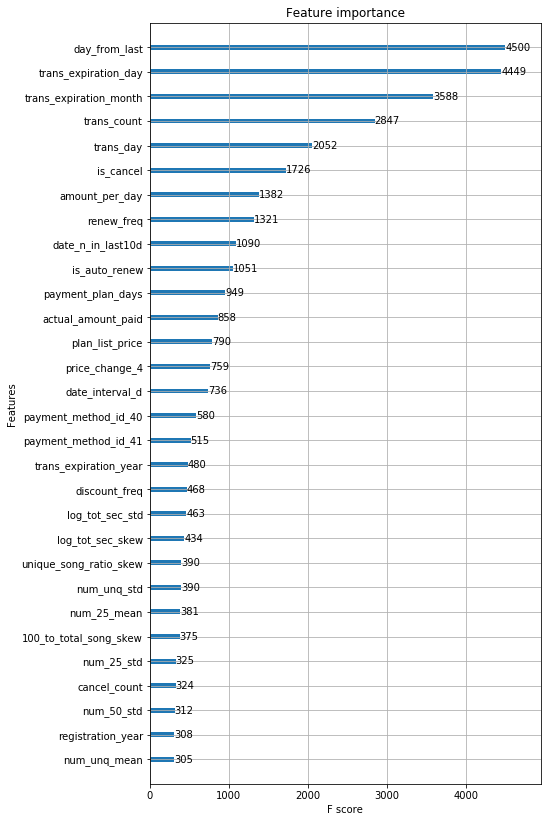